In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive #remove this cell when running on local
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print("Model device:", device)

Model device: cuda


In [ ]:
#Loading data

df_train = pd.read_csv('/content/drive/MyDrive/BU-Project/kaggle-training-data/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/BU-Project/kaggle-training-data/test.csv')


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/BU-Project/kaggle-training-data/train.csv'

Training Data Processing

In [ ]:
#Drop Unused Data
df_train = df_train.drop(['PassengerId', 'Name'], axis=1)

In [ ]:
df_train[["Deck", "Cabin_num", "Side"]] = df_train["Cabin"].str.split("/", expand=True)

In [ ]:
#Process Needed Data
df_train[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomService']] = df_train[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomService']].fillna(value=0)
df_train["Transported"] = df_train["Transported"].astype(int)
df_train['VIP'] = df_train['VIP'].astype(int)
df_train['CryoSleep'] = df_train['CryoSleep'].astype(int)
df_train['Destination'] = df_train['Destination'].astype('category')
df_train['Destination'] = df_train['Destination'].cat.codes
df_train['HomePlanet'] = df_train['HomePlanet'].astype('category')
df_train['HomePlanet'] = df_train['HomePlanet'].cat.codes
df_train['Deck'] = df_train['Deck'].astype('category')
df_train['Deck'] = df_train['Deck'].cat.codes
df_train['Side'] = df_train['Side'].astype('category')
df_train['Side'] = df_train['Side'].cat.codes
df_train[['Side', 'Deck', 'Cabin_num']] = df_train[['Side', 'Deck', 'Cabin_num']].fillna(value=0)
df_train['Age'] = df_train['Age'].fillna(value=df_train['Age'].mean())

In [ ]:
try:
    df_train = df_train.drop('Cabin', axis=1)
except KeyError:
    print("Field does not exist")

In [ ]:
x, y = df_train.drop('Transported', axis=1), df_train['Transported']

In [ ]:
torch.manual_seed(41)#fix the random seed

Testing and Training

Test Data Processing

In [ ]:
submission_id = df_test['PassengerId']
submission_name = df_test['Name']

In [ ]:
df_test = df_test.drop(['PassengerId', 'Name'], axis=1)

In [ ]:
df_test[["Deck", "Cabin_num", "Side"]] = df_test["Cabin"].str.split("/", expand=True)

In [ ]:
df_test[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomService']] = df_train[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomService']].fillna(value=0)
df_test['VIP'] = df_test['VIP'].astype(int)
df_test['CryoSleep'] = df_test['CryoSleep'].astype(int)
df_test['Destination'] = df_test['Destination'].astype('category')
df_test['Destination'] = df_test['Destination'].cat.codes
df_test['HomePlanet'] = df_test['HomePlanet'].astype('category')
df_test['HomePlanet'] = df_test['HomePlanet'].cat.codes
df_test['Deck'] = df_test['Deck'].astype('category')
df_test['Deck'] = df_test['Deck'].cat.codes
df_test['Side'] = df_test['Side'].astype('category')
df_test['Side'] = df_test['Side'].cat.codes
df_test[['Side', 'Deck', 'Cabin_num']] = df_test[['Side', 'Deck', 'Cabin_num']].fillna(value=0)
df_test['Age'] = df_test['Age'].fillna(value=df_test['Age'].mean())

In [ ]:
try:
    df_test = df_test.drop('Cabin', axis=1)
except KeyError:
    print("Field does not exist")

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=41)

In [ ]:
x_train = x_train.astype(float) # Convert to numeric type
y_train = y_train.astype(int)  # Convert to numeric type
x_test = x_test.astype(float)   # Convert to numeric type
y_test = y_test.astype(int)    # Convert to numeric type

x_train = torch.FloatTensor(x_train.values)
y_train = torch.FloatTensor(y_train.values)
x_test = torch.FloatTensor(x_test.values)
y_test = torch.FloatTensor(y_test.values)

x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

Main Model

In [ ]:
#Network here
class PassengerClassifier(nn.Module): #Feedf_trainorward NN
  """
    Input 12 features: a large matrix of values of each attribute
    Hidden layers: denoted as h1, h2 ......
    Output layers: 1 for true(transported) and 0 for false(failed transport)

  """

  def __init__(self, input_layer=13, h1=64, h2=64, h3=32, h4=40, h5=20 , output_layer=1):
    super().__init__()
    self.fc1 = nn.Linear(input_layer, h1)#Fully connect the input layer and hidden layer h1
    self.fc2 = nn.Linear(h1, h2)#Fully connect the hidden layer h1 and hidden layer h2
    self.fc3 = nn.Linear(h2, h3)
    #self.fc4 = nn.Linear(h3, h4)
    #self.fc5 = nn.Linear(h4, h5)
    self.out = nn.Linear(h3, output_layer)#Fully connect the hidden layer h3 and output layer


  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    #x = F.relu(self.fc4(x))
    #x = F.relu(self.fc5(x))
    x = self.out(x)

    return x

In [ ]:
model_test = PassengerClassifier()
model_submission = PassengerClassifier()
model_test.to(device)

PassengerClassifier(
  (fc1): Linear(in_features=13, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
#Define Loss Function and Optimiser
Loss = nn.BCEWithLogitsLoss()



Optimiser_S = torch.optim.SGD(model_test.parameters(), lr=0.00005, momentum=0.9, nesterov=True, weight_decay=1e-4 )


Optimiser_A = torch.optim.Adam(model_test.parameters(), lr=0.001, weight_decay=1e-4)
#Optimiser = torch.optim.Adam(model_submission.parameters(), lr=0.005)

scheudlar = torch.optim.lr_scheduler.StepLR(Optimiser_S, step_size=10000, gamma=0.1)

In [ ]:
#Training Loop
epochs = 100000
list_loss = []
for i in range(epochs):
  y_pred = model_test.forward(x_train)

  loss = Loss(y_pred, y_train.unsqueeze(1))

  if i % 1000 == 0:
    list_loss.append(loss)
    print(f"Epoch: {i} Loss: {loss}")

  if i < 200000:

    Optimiser_A.zero_grad()
    loss.backward()
    Optimiser_A.step()

  else:
    Optimiser_S.zero_grad()
    loss.backward()
    Optimiser_S.step()
    scheudlar.step()


Epoch: 0 Loss: 12.935687065124512
Epoch: 1000 Loss: 0.37816134095191956
Epoch: 2000 Loss: 0.3529908359050751
Epoch: 3000 Loss: 0.2959167957305908
Epoch: 4000 Loss: 0.29746678471565247
Epoch: 5000 Loss: 0.2561090886592865
Epoch: 6000 Loss: 0.3005833327770233
Epoch: 7000 Loss: 0.22718439996242523
Epoch: 8000 Loss: 0.23463620245456696
Epoch: 9000 Loss: 0.22181005775928497
Epoch: 10000 Loss: 0.30770277976989746
Epoch: 11000 Loss: 0.1998187154531479
Epoch: 12000 Loss: 0.2014063149690628
Epoch: 13000 Loss: 0.20107398927211761
Epoch: 14000 Loss: 0.19166846573352814
Epoch: 15000 Loss: 0.201689213514328
Epoch: 16000 Loss: 0.29751062393188477
Epoch: 17000 Loss: 0.17806154489517212
Epoch: 18000 Loss: 0.1850041002035141
Epoch: 19000 Loss: 0.1681007593870163
Epoch: 20000 Loss: 0.17419175803661346
Epoch: 21000 Loss: 0.17145474255084991
Epoch: 22000 Loss: 0.16444724798202515
Epoch: 23000 Loss: 0.16683824360370636
Epoch: 24000 Loss: 0.21494922041893005
Epoch: 25000 Loss: 0.1648576557636261
Epoch: 2600

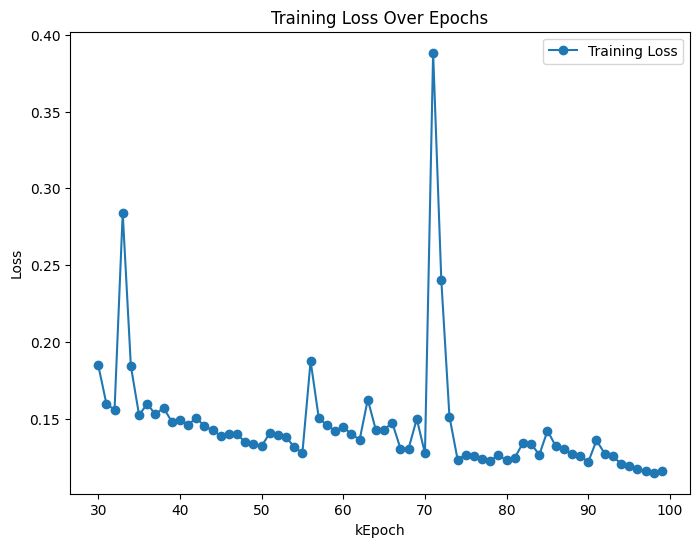

In [ ]:
loss_values = [loss.item() for loss in list_loss]
loss_values = np.array(loss_values)
loss_values = loss_values[30:]
plt.figure(figsize=(8, 6))
plt.plot(range(30, epochs//1000), loss_values, marker='o', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('kEpoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Evaluation
def accuaracy(pred, truth):
  counter = 0
  for i in range(pred.shape[0]):
    if pred[i] == truth[i]:
      counter += 1
  return counter/pred.shape[0]

prediction = model_test(x_test)
print(prediction)
predictions = (prediction >= 0).bool()# because it is raw logist
print(predictions)

print(accuaracy(predictions, y_test))


tensor([[  2.6150],
        [-25.8058],
        [ -1.1110],
        ...,
        [-24.2846],
        [-56.6237],
        [  2.2260]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ True],
        [False],
        [False],
        ...,
        [False],
        [False],
        [ True]], device='cuda:0')
0.7521564117308798


Submission

In [ ]:
x = x.astype(float) # Convert to numeric type
y = y.astype(int)  # Convert to numeric type
x = torch.FloatTensor(x.values)
y = torch.FloatTensor(y.values)

In [ ]:
epochs = 100000
for i in range(epochs):
  y_pred = model_submission.forward(x)


  loss = Loss(y_pred, y.unsqueeze(1))

  if i % 10000 == 0:
    print(f"Epoch: {i} Loss: {loss}")
  Optimiser.zero_grad()
  loss.backward()
  Optimiser.step()
  scheudlar.step()

Epoch: 0 Loss: 7.686885356903076
Epoch: 10000 Loss: 0.327757865190506
Epoch: 20000 Loss: 0.27072352170944214
Epoch: 30000 Loss: 0.24028068780899048
Epoch: 40000 Loss: 0.22965790331363678
Epoch: 50000 Loss: 0.22690154612064362
Epoch: 60000 Loss: 0.22547489404678345
Epoch: 70000 Loss: 0.22519928216934204
Epoch: 80000 Loss: 0.22495147585868835
Epoch: 90000 Loss: 0.22492271661758423


In [ ]:
df_test

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Deck,Cabin_num,Side
0,0013_01,1,0,3,27.000000,0,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,6,3,1
1,0018_01,1,0,3,19.000000,0,109.0,9.0,25.0,549.0,44.0,Lerome Peckers,5,4,1
2,0019_01,2,0,1,31.000000,1,43.0,3576.0,0.0,6715.0,49.0,Sabih Unhearfus,2,0,1
3,0021_01,2,0,3,38.000000,0,0.0,1283.0,371.0,3329.0,193.0,Meratz Caltilter,2,1,1
4,0023_01,1,0,3,20.000000,0,303.0,70.0,151.0,565.0,2.0,Brence Harperez,5,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,1,0,3,34.000000,0,0.0,1.0,0.0,17.0,1601.0,Jeron Peter,6,1496,1
4273,9269_01,1,0,3,42.000000,0,0.0,180.0,516.0,0.0,0.0,Matty Scheron,-1,0,-1
4274,9271_01,3,0,1,28.658146,0,375.0,103.0,1990.0,36.0,0.0,Jayrin Pore,3,296,0
4275,9273_01,2,0,0,28.658146,1,0.0,102.0,0.0,278.0,5353.0,Kitakan Conale,3,297,0


In [ ]:
df_test = df_test.astype(float)
df_test = torch.FloatTensor(df_test.values)

In [ ]:
prediction = model_submission(df_test)
predictions = (prediction >= 0).bool()

In [ ]:
df_submission = pd.read_csv('/content/drive/MyDrive/BU-Project/kaggle-training-data/sample_submission.csv')
df_submission['Transported'] = predictions
df_submission.to_csv('/content/drive/MyDrive/BU-Project/kaggle-training-data/submission.csv', index=False)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,True
